In [13]:
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold

import matplotlib
import matplotlib.pyplot as plt

In [2]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [3]:
from sklearn.metrics import r2_score

In [4]:
import sys
sys.path.append('../lib')

import XgbAdjustmentHelper as xgbhelper
import SklearnModelCurve as curve_helper

In [5]:
munged_train_df = pd.read_csv('../data/offline/train.csv', index_col=0)
munged_test_df = pd.read_csv('../data/offline/test.csv', index_col=0)
y_train_df = pd.read_csv('../data/offline/y_train.csv', index_col=0)

X_train, X_test, y_train, y_test = train_test_split(munged_train_df.values, y_train_df.values, test_size=0.5, random_state=1729)
X_all_train = munged_train_df.values
y_all_train = y_train_df['y'].values

In [6]:
feature_names = munged_train_df.columns

In [3]:
# xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,
#                              silent=False, objective='reg:linear', subsample=0.8,
#                              colsample_bytree=0.8, gamma=0, min_child_weight = 1,
#                              scale_pos_weight=1, seed=27)

# feat_data = xgbhelper.ModelFit(xgb_model, feature_names, X_train, y_train, X_test, y_test, 13)
# plt.show()

In [ ]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.8, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27)

params2 = {
 'max_depth':[4],
 'min_child_weight':[7, 8, 9, 10]
}
search = xgbhelper.ModelParamSearch(xgb_model, params2, X_all_train, y_all_train, 'r2')


params = search.best_params_
params['learning_rate'] = []

In [9]:
xgb_model.get_xgb_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 48,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': 0,
 'subsample': 0.8}

In [48]:
def objective(params):
    print("Training with params : ")
    print(params)
    params['max_depth'] = np.int(params['max_depth'])
    num_boost_round = 400;
    early_stopping_rounds = 50;
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_boost_round = num_boost_round)
    y_predict = model.predict(dvalid)
    score = r2_score(y_test, y_predict)
    loss = 1- score
    print("\tScore {0}\n\n".format(score))
    return {'loss': loss, 'status': STATUS_OK}

In [55]:
def optimize():
    space = {
             'eta' : 0.1,
             'max_depth' : hp.quniform('max_depth', 3, 6, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 9, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0, 0.5, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             #'eval_metric': 'mlogloss',
             'objective': 'reg:linear',
             'silent' : 1,
             'reg_alpha' : hp.loguniform('reg_alpha', 1e-5, 10),
             }

    best = fmin(objective, space, algo=tpe.suggest, max_evals=1)
    return best;

In [56]:
best = optimize()

Training with params : 
{'objective': 'reg:linear', 'reg_alpha': 3.1405518350381216, 'gamma': 0.05, 'colsample_bytree': 0.55, 'max_depth': 5.0, 'subsample': 0.9, 'min_child_weight': 3.0, 'silent': 1, 'eta': 0.1}
	Score 0.4496376268485197




In [ ]:
def ModelLearnRateSearch(params, learning_rates, num_bounds):
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    xgb_model = xgb.XGBRegressor()
    xgb_model.set_params(**params)
    best_score = 0
    best_params = {}
    
    for lr in learning_rates:
        
        params['learning_rate'] = lr
        cvresult = xgb.cv(params, xgtrain, num_boost_round=num_bounds, nfold=5,
                          metrics='rmse', early_stopping_rounds=50)
        
        valid_round = cvresult.shape[0]
        xgb_model.set_params(n_estimators = cvresult.shape[0], learning_rate = lr)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        score = r2_score(y_test, y_pred)
        print("lr:%f  n_estimators:%d  score:%f"%(lr, valid_round, score))
        if best_score < score:
            best_score = score
            best_params['n_estimators'] = valid_round
            best_params['learning_rate'] = lr
            
        print(xgb_model.get_params())
    return best_score, best_params

In [31]:
init_param = {
    'learning_rate':0.1,
    'n_estimators':100,
    'silent':True,
    'objective':'reg:linear',
    'seed':27,
}

adjust_param = {
    'max_depth':[3, 4, 5],
    'min_child_weight':[7, 8, 9, 10],
    'subsample':[i/100.0 for i in range(70, 105, 5)],
    'colsample_bytree':[i/100.0 for i in range(70, 105, 5)],
    'gamma':[i/100.0 for i in range(0, 30, 5)],
    'reg_alpha':[1e-5, 1e-4, 1e-3,1e-2,1e-1, 1, 10],
}

init_param = {
    'learning_rate':0.1,
    'n_estimators':100,
    'silent':False,
    'objective':'reg:linear',
    'seed':27,
    
    'min_child_weight':6,
    'subsample':1,
    'colsample_bytree':0.9,
    'gamma':0
}

adjust_param = {
    'max_depth':[3, 4],
}

xgb_model = xgb.XGBRegressor()
xgb_model.set_params(**init_param)
search = xgbhelper.ModelParamSearch(xgb_model, adjust_param, X_all_train, y_all_train, 'r2')

combine_param = dict(init_param, **search.best_params_)

score, params = ModelLearnRateSearch(combine_param, [0.1], 1000)
combine_param['n_estimators'] = params['n_estimators']
combine_param['learning_rate'] = params['learning_rate']
xgb_model.set_params(**combine_param)
xgb_model


grid_scores
mean: 0.54869, std: 0.07060, params: {'max_depth': 3}
mean: 0.53929, std: 0.06877, params: {'max_depth': 4}

best_params
{'max_depth': 3}

best_score
0.5486895401921688


In [35]:
def KFoldCV(model, num_fold, X_train, y_train):
    cv_results = []
    kf = KFold(n_splits=num_fold, random_state=27)
    for train_index, test_index in kf.split(X_train):
        X_train, X_test = X_train[train_index], X_train[test_index]
        y_train, y_test = y_train[train_index], y_train[test_index]
        model.fit(X_train, X_test)
        y_pred = model.predict(X_test, y_test)
        score = r2_score(y_test, y_pred)
        cv_results.append(score)
    print('mean:%f std:%f'%(np.mean(cv_results), np.std(cv_results)))

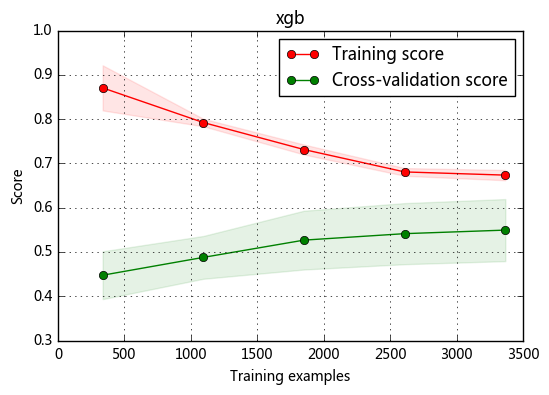

In [14]:
curve_helper.plot_learning_curve(xgb_model, 'xgb', X_all_train, y_all_train, cv=5)

In [15]:
xgb_model.fit(X_all_train, y_all_train)
y_pred = xgb_model.predict(munged_test_df.values)
output = pd.DataFrame({'id': munged_test_df.index, 'y': y_pred})
output.to_csv('../data/online/xgboost-pca-ica-grp-srp-6-9-1.csv', index=False)

In [22]:
y_pred

array([ 69.72631073,  83.14871979,  70.18686676, ...,  82.90158844,
        98.74907684,  83.40969849], dtype=float32)